In [1]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
def generateRandomSignal():
    t0 =  random.uniform(10**(-3), 1)
    f0 = 1 / t0

    fs = np.array([i*(random.random() < 0.5) for i in range(15)])
    
    a = np.array([random.random()*4 for i in range(15)])
    phi = np.array([random.random()*2*np.pi for i in range(15)])

    return np.vectorize(lambda t: np.sum(a*np.sin(2*np.pi*t*fs + phi)))

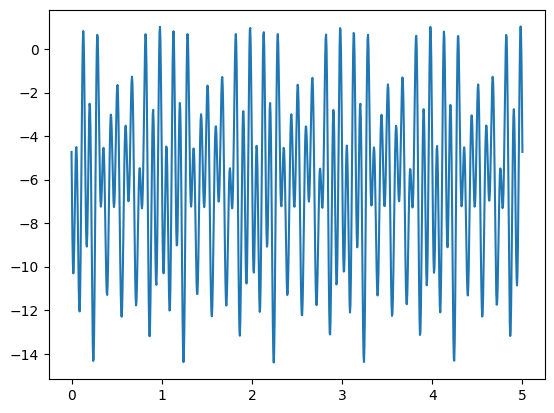

In [ ]:
f = generateRandomSignal()
t = np.linspace(0, 5, 1000)
values = f(t)
plt.plot(t, values)

In [7]:
def apply_peak_noise(_x, target_column_numerical, leng, device="cpu"):
    peak_index = np.random.randint(0, leng)
    peak_value = (_x[target_column_numerical, peak_index] < 0.5).float().to(device)
    peak_value = peak_value + (0.1 * (1 - 2 * peak_value)) * torch.rand(len(target_column_numerical), device=device)
    _x[target_column_numerical, peak_index] = peak_value
    return _x, peak_index

def apply_noise(x, target_column_numerical, leng, patch_size=4, device="cpu"):
    tar = random.randint(0,len(x) - leng)
    _x = x[tar: tar + leng].clone().T
    _x, peak_index = apply_peak_noise(_x, target_column_numerical, leng, device=device)
    x[tar: tar + leng] = _x.T
    x_anomaly = torch.zeros_like(x)
    peak_index = tar + peak_index
    tar_first = np.maximum(0, peak_index - patch_size)
    tar_last = peak_index + patch_size + 1#index out of bound de temps en temps ?
    x_anomaly[tar_first:tar_last] = 1
    return x, x_anomaly

def signal_test(f,t):
    signal = f(t)
    signal = torch.from_numpy(signal).clone()

    if signal.ndim == 1:
        signal_2d = signal.unsqueeze(-1)  # -> (1, T)
    else:
        signal_2d = signal.T

    max_val = torch.abs(signal_2d).max()
    if max_val > 0:
        signal_2d = signal_2d / max_val

    signal_2d = signal_2d.to(torch.float32)

    return signal_2d

def apply_noise_from_signal(f, leng=100, signal_size=4_000, patch_size=4, device="cpu"):
    t = np.linspace(0, signal_size//500, signal_size)
    x = signal_test(f,t)
    leng = int(leng + (0.5 - random.random())*leng/5)
    x, x_anomaly = apply_noise(x, [0], leng, patch_size=patch_size, device=device)
    return x, x_anomaly

def create_dummy_test(batch_size=64, leng=100, signal_size=4_000, patch_size=4, device="cpu"):
    batch = [apply_noise_from_signal(generateRandomSignal(), leng=leng, signal_size=signal_size, patch_size=patch_size, device=device) for i in range(batch_size)]
    return batch

In [8]:
data = create_dummy_test(device="cuda")